In [109]:
import numpy as numpy
import pandas as pd
import math 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#create function to identify which galaxy an x-ray flash or variable star is in
#home function (because it finds star's home)
def home(ax, ay, bx, by, length):
    closestradius=1e12
    for counter in range (0, length):
        #radius is distance between star/flash and galaxy
        radius=math.sqrt((ax[counter]-bx)**2+(ay[counter]-by)**2)
        if radius< closestradius:
            closestradius=radius 
            #value is the identifier of the galaxy we have found the star/flash to be closest to
            value=counter
    return value

#read in data from AllGalaxies
gData = pd.read_csv("AllGalaxies.csv", index_col="Name")
gx = gData['X'].to_numpy() #x coord of galaxy 
gy = gData['Y'].to_numpy()
length=len(gx)
gdlist =[0.0]*length

#read in data from LongVariables.csv to a panda and then into numpy arrays
vData = pd.read_csv("LongVariables.csv", index_col="Name")
vx = vData['X'].to_numpy() #x-coord of variable star
vy = vData['Y'].to_numpy()
vdlist=vData['Distance'].to_numpy() #distance of star from NewEarth 

#read in data from x-ray flashes
flashData = pd.read_csv("Flash_Data.csv", index_col="Name")
fx = flashData['X'].to_numpy() #x cood of flash 
fy = flashData['Y'].to_numpy()
fp=flashData['PhotonCount'].to_numpy()
n=len(fx)
fXlist=[0.0]*n
fdlist =[0.0]*n

In [110]:
#identify a home galaxy for each of the variable star
l=len(vx)

#repeat for every star
for star in range(0, l):
    #get coords of star
    bx=vx[star]
    by=vy[star]
    #find home galaxy
    answer=home(gx, gy, bx, by, length) #returns index of home galaxy 
    gdlist[answer]=vdlist[star]

In [111]:
#identify k closest flashes
k=7
highestFlashes=flashData.nlargest(k,'PhotonCount')

#numpy arrays hfx means x co-ord of highest flash 
hfx = highestFlashes['X'].to_numpy()
hfy = highestFlashes['Y'].to_numpy()
hfi=highestFlashes['I'].to_numpy()
photonCountList = highestFlashes['PhotonCount'].to_numpy()
hfdlist =[0]*k


In [112]:
#identify a home galaxy for each of the highest flashes

#repeat for every flash 
for i in range(0, k):
    #get coords of x-ray flash
    bx=hfx[i]
    by=hfy[i]
    #find home galaxy
    identifier=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #distance of the xray flash= distance of closest galaxy 
    hfdlist[i]=gdlist[identifier]

 

In [113]:
#plot distance versus photon count for highest x-ray flashes

xList=[0.0]*k

#x=1/d^2, find x for each d and store in parallel array
for a in range (0, k):
    if hfdlist[a]>0:
        xList[a]=1/(hfdlist[a]**2)

graphdf = pd.DataFrame(data=[xList, photonCountList], index=['newxlist', 'plist']).T
graphdf.query('newxlist>0', inplace=True)
finalxlist = graphdf['newxlist'].to_numpy()
finalplist = graphdf['plist'].to_numpy()



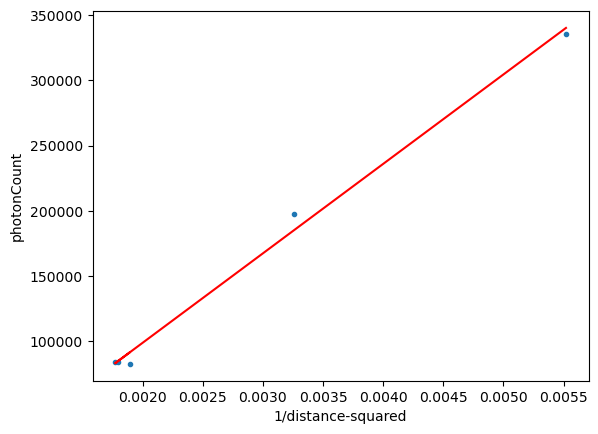

In [114]:
#plot line and find gradient m

A = numpy.vander(finalxlist,2) 
# the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc

b, residuals, rank, s = numpy.linalg.lstsq(A,finalplist)
#print('parameters: %.2f, %.2f' % (b[0],b[1]))
m=b[0]

reconstructed = A @ b # @ is shorthand for matrix multiplication in python

plt.plot(finalxlist,finalplist,'.')
plt.plot(finalxlist,reconstructed,'-r')
plt.xlabel("1/distance-squared")
plt.ylabel("photonCount")
plt.show()

46


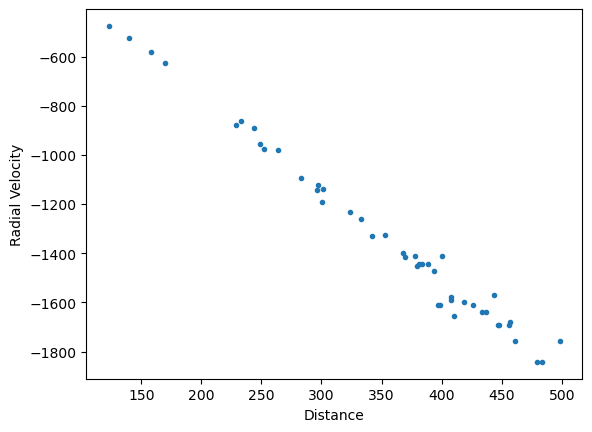

In [115]:
#new flashData column distance 
fXlist= fp/m
fdlist=numpy.sqrt(1/fXlist)

newgdlist=[0.0]*length
#find galaxy for each flash 
for q in range(0, n):
    #get coords of x-ray flash
    bx=fx[q]
    by=fy[q]
    #find home galaxy
    p=home(gx, gy, bx, by, length) #returns index of home galaxy 

    #save distance for each galaxy 
    newgdlist[p]=fdlist[q]

#filter galaxies with distance greater than 0
gData['Distance'] = newgdlist
gData.query('Distance>60.0', inplace=True)
print(len(gData.index))

DistanceList = gData['Distance'].to_numpy()
VelocityList = gData['RadialVelocity'].to_numpy()

plt.plot(DistanceList,VelocityList,'.')
plt.xlabel("Distance")
plt.ylabel("Radial Velocity")
plt.show()

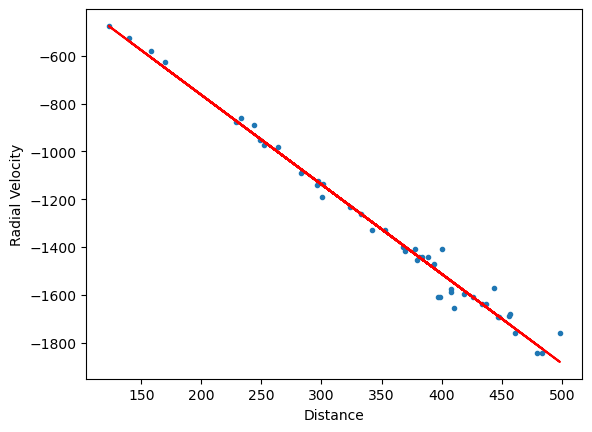

The hubble constant is: -3.743882702953831


In [116]:
#plot line and find gradient m

A2 = numpy.vander(DistanceList,2) 
# the Vandermonde matrix of order N is the matrix of polynomials of an input vector 1, x, x**2, etc

b2, residuals2, rank2, s2 = numpy.linalg.lstsq(A2,VelocityList)
#print('parameters: %.2f, %.2f' % (b2[0],b2[1]))
m2=b2[0]

reconstructed2 = A2 @ b2 # @ is shorthand for matrix multiplication in python

plt.plot(DistanceList,VelocityList,'.')
plt.plot(DistanceList,reconstructed2,'-r')
plt.xlabel("Distance")
plt.ylabel("Radial Velocity")
plt.show()

print("The hubble constant is:", m2)